In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import mdtraj
import deep_boltzmann
from deep_boltzmann.networks.training import MLTrainer, FlexibleTrainer
from deep_boltzmann.networks.invertible import invnet, EnergyInvNet, InvNet
from deep_boltzmann.openmmutils import save_latent_samples_as_trajectory
from deep_boltzmann.models.openmm import OpenMMEnergy
import mdtraj as md
from simtk import openmm, unit

import sys, os, shutil
import tensorflow as tf

In [2]:
from IPython import display
display.set_matplotlib_formats("svg")

In [3]:
print("Tensorflow Version:", tf.__version__)

Tensorflow Version: 2.5.0


In [4]:
pdb_model = mdtraj.load_pdb('pdz3_rat_apo_fixed.pdb')

In [5]:
traj = mdtraj.load("traj.h5")
sim_x = traj.xyz
print(sim_x.shape)

(100000, 1655, 3)


In [6]:
def setup_protein(pdbmodel_dir):
    """ Sets up protein Topology and Energy Model

    Returns
    -------
    top : mdtraj Topology object
        Protein topology
    energy : Energy object
        Energy model

    """
    # 4C in KIW's experiment
    INTEGRATOR_ARGS = (277*unit.kelvin, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)

    from simtk.openmm import app
    pdb = app.PDBFile(pdbmodel_dir)
    forcefield = openmm.app.ForceField('amber14/protein.ff14SB.xml', 'amber14/tip3p.xml')

    system = forcefield.createSystem(pdb.topology,removeCMMotion=False,
                                     nonbondedMethod=app.CutoffNonPeriodic, nonbondedCutoff=1.0*unit.nanometers,
                                     constraints=None, rigidWater=True)
    integrator = openmm.LangevinIntegrator(277*unit.kelvin, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)
    simulation = openmm.app.Simulation(pdb.topology, system, integrator)

    protein_omm_energy = OpenMMEnergy(system,
                                   openmm.LangevinIntegrator,
                                   unit.nanometers,
                                   n_atoms=md.Topology().from_openmm(simulation.topology).n_atoms,
                                   openmm_integrator_args=INTEGRATOR_ARGS)

    mdtraj_topology = md.Topology().from_openmm(pdb.topology)
    return mdtraj_topology, protein_omm_energy

def get_indices(top, cartesian_CYS=True):
    """ Returns Cartesian and IC indices

    Returns
    -------
    cart : array
        Cartesian atom selection
    Z : array
        Z index matrix

    """
    from deep_boltzmann.models.proteins import mdtraj2Z
    cartesian = ['CA', 'C', 'N']
    cart = top.select(' '.join(["name " + s for s in cartesian]))
    if cartesian_CYS:
        Z_, _carts = mdtraj2Z(top,  cartesian="resname CYS and mass>2 and sidechain")
        Z_ = np.array(Z_)
        cart = np.sort(np.concatenate((cart,_carts)))
    else:
        Z_ = np.array(mdtraj2Z(top))
    return cart, Z_

In [7]:
def train_ML(bg, xtrain, epochs, batch_sizes):
    trainer_ML = MLTrainer(bg, lr=0.001)
    for batch_size in batch_sizes:
        trainer_ML.train(xtrain, epochs=epochs, batch_size=batch_size)
    return trainer_ML

In [8]:
def train_KL(bg, xtrain, epochs, high_energies, w_KLs, stage=0, rc_dims=None, rc_func=None, rc_min=None, 
             rc_max=None, w_RC=0., w_L2_angle=0., loss_track=[], file_name="./BG_intermediate_model_saved_TF2_longML.pkl"):
    #trainers_KL_state3 = []
    for current_stage in range(stage, len(epochs)):
        print('-----------------------')
        print(high_energies[current_stage], w_KLs[current_stage])
        sys.stdout.flush()
        flextrainer = FlexibleTrainer(bg, lr=0.0001, batch_size=2000,
                                      high_energy=high_energies[current_stage], max_energy=1e20,
                                      w_KL=w_KLs[current_stage], w_ML=1, weigh_ML=False, w_RC=w_RC,
                                      rc_func=rc_func, rc_min=np.array(rc_min), rc_max=np.array(rc_max),
                                      w_L2_angle=w_L2_angle, 
                                      rc_dims=rc_dims)
        flextrainer.train(xtrain, epochs=epochs[current_stage])
        #trainers_KL_state3.append(flextrainer)
        loss_track.extend(flextrainer.loss_train)

        # Analyze
        samples_z = np.random.randn(2000, bg.dim)
        samples_x = bg.Tzx.predict(samples_z)[0]
        samples_e = bg.energy_model.energy(samples_x)
        energy_violations = [np.count_nonzero(samples_e > E) for E in high_energies]
        print('Energy violations:')
        for E, V in zip(high_energies, energy_violations):
            print(V, '\t>\t', E)
        sys.stdout.flush()

        # SAVE
        bg.save(file_name)
        saveconfig = {}
        saveconfig['stage'] = current_stage
        #np.savez_compressed('config_save.npz', **saveconfig)
        print('Intermediate result saved')
        sys.stdout.flush()
    return loss_track

### Set up a BG network

In [9]:
top, mm_pdz = setup_protein('pdz3_rat_apo_fixed.pdb')

In [10]:
# Superimpose frames and reshuffle 
nframes = sim_x.shape[0]
dim = sim_x.shape[1]*sim_x.shape[2]
sim_x_traj = mdtraj.Trajectory(sim_x.reshape((nframes, int(dim/3), 3)), top)
sim_x_traj = sim_x_traj.superpose(sim_x_traj[0], atom_indices=top.select('backbone'))
sim_x = sim_x_traj.xyz.reshape((nframes, -1))
np.random.shuffle(sim_x)

In [11]:
# Get indices for dimensions represented by cartesian and internal coordinates respectively
CartIndices, ZIndices = get_indices(top, cartesian_CYS=False)

In [12]:
# Construct Boltzmann Generator object 
bg = invnet(dim, 'R'*8, energy_model=mm_pdz,
            ic=np.asarray(ZIndices,dtype=np.int), ic_cart=np.asarray(CartIndices,dtype=np.int), ic_norm=sim_x,
            nl_layers=4, nl_hidden=[256, 128, 256], nl_activation='relu', nl_activation_scale='tanh')
print('BG constructed\n')
sys.stdout.flush()

I<RRRRRRRR>
I 4965 0 0
< 4959 0 6
R 2480 2479 6
R 2480 2479 6
R 2480 2479 6
R 2480 2479 6
R 2480 2479 6
R 2480 2479 6
R 2480 2479 6
R 2480 2479 6
> 2480 2479 6
Before connect
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Done xz
Done zx
BG constructed



### ML Training with MD-generated Dataset, longer Epoch

In [13]:
# Perform ML training -- 6 epochs with increasing batch sizes
epochs_ML = 2000
batch_sizes_ML = [128, 256, 512, 512, 1024, 1024]
trainer_ML = train_ML(bg, sim_x, epochs_ML, batch_sizes_ML)
bg.save('./BG_save_after_ML_TF2_longerML.pkl')

print('ML training done\n')
sys.stdout.flush()

Epoch 0/2000 ML Loss Value -18060.0625 
Epoch 1/2000 ML Loss Value -18678.6445 
Epoch 2/2000 ML Loss Value -18737.4336 
Epoch 3/2000 ML Loss Value -18737.3438 
Epoch 4/2000 ML Loss Value -18811.5078 
Epoch 5/2000 ML Loss Value -18819.2949 
Epoch 6/2000 ML Loss Value -18867.4453 
Epoch 7/2000 ML Loss Value -18879.9766 
Epoch 8/2000 ML Loss Value -18909.3281 
Epoch 9/2000 ML Loss Value -18888.4258 
Epoch 10/2000 ML Loss Value -18899.7090 
Epoch 11/2000 ML Loss Value -18910.8535 
Epoch 12/2000 ML Loss Value -18935.7598 
Epoch 13/2000 ML Loss Value -18924.3359 
Epoch 14/2000 ML Loss Value -18905.2168 
Epoch 15/2000 ML Loss Value -18938.6348 
Epoch 16/2000 ML Loss Value -18932.2422 
Epoch 17/2000 ML Loss Value -18919.3398 
Epoch 18/2000 ML Loss Value -18920.6816 
Epoch 19/2000 ML Loss Value -18936.8008 
Epoch 20/2000 ML Loss Value -18917.3555 
Epoch 21/2000 ML Loss Value -18932.1523 
Epoch 22/2000 ML Loss Value -18963.5273 
Epoch 23/2000 ML Loss Value -18937.6562 
Epoch 24/2000 ML Loss Valu

In [13]:
bg = InvNet.load("BG_save_after_ML_TF2_longerML.pkl")

Before connect
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Done xz
Done zx


In [14]:
epochs_ML = 2000
batch_sizes_ML = [1024, 1024, 1024]
trainer_ML = train_ML(bg, sim_x, epochs_ML, batch_sizes_ML)
bg.save('./BG_save_after_ML_TF2_longerML2.pkl')

Epoch 0/2000 ML Loss Value -19752.2656 
Epoch 1/2000 ML Loss Value -18030.4102 
Epoch 2/2000 ML Loss Value -19135.6367 
Epoch 3/2000 ML Loss Value -19202.1797 
Epoch 4/2000 ML Loss Value -19196.8008 
Epoch 5/2000 ML Loss Value -19241.6914 
Epoch 6/2000 ML Loss Value -19312.4414 
Epoch 7/2000 ML Loss Value -19350.2441 
Epoch 8/2000 ML Loss Value -19377.2305 
Epoch 9/2000 ML Loss Value -19406.1055 
Epoch 10/2000 ML Loss Value -19419.7969 
Epoch 11/2000 ML Loss Value -19445.2832 
Epoch 12/2000 ML Loss Value -19453.2891 
Epoch 13/2000 ML Loss Value -19472.9707 
Epoch 14/2000 ML Loss Value -19481.8555 
Epoch 15/2000 ML Loss Value -19494.5566 
Epoch 16/2000 ML Loss Value -19507.5508 
Epoch 17/2000 ML Loss Value -19515.8008 
Epoch 18/2000 ML Loss Value -19526.1758 
Epoch 19/2000 ML Loss Value -19541.1016 
Epoch 20/2000 ML Loss Value -19548.7227 
Epoch 21/2000 ML Loss Value -19556.9062 
Epoch 22/2000 ML Loss Value -19565.1094 
Epoch 23/2000 ML Loss Value -19574.7578 
Epoch 24/2000 ML Loss Valu

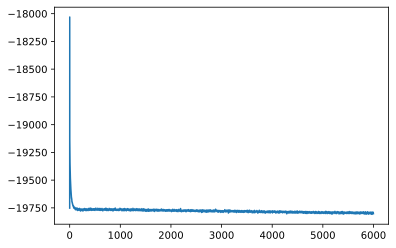

In [15]:
plt.plot(trainer_ML.loss_train)
plt.show()

### KL + ML Flexible Training

In [36]:
bg = EnergyInvNet.load("./BG_save_after_ML_TF2_longerML2.pkl", mm_pdz)

Before connect
Done xz
Done zx


In [39]:
saveconfig = {}
# Train KL
saveconfig['stage'] = 0

epochs_KL     = [  15,   15,   15,   15,   15,   15,  20,  20,  30, 50, 50, 300]
high_energies = [1e10,  1e9,  1e8,  1e7,  1e6,  1e5,  1e5,  1e5,  5e4,  5e4,  2e4,  2e4]
w_KLs         = [1e-12, 1e-6, 1e-5, 1e-4, 1e-3, 1e-3, 5e-3, 1e-3, 5e-3, 5e-2, 0.05, 0.1]
loss_track = train_KL(bg,  sim_x, epochs_KL, high_energies, w_KLs, stage = saveconfig['stage'],w_L2_angle=1.0, loss_track=[])

-----------------------
10000000000.0 1e-12
Epoch 0/15 Overall Loss 56811.1484 ML Loss -19796.3125 KL Loss 544118528.0000 L2 Angle Loss 76607.4531 
Epoch 1/15 Overall Loss 5857.8213 ML Loss -19788.7891 KL Loss 558936640.0000 L2 Angle Loss 25646.6113 
Epoch 2/15 Overall Loss -234.6116 ML Loss -19742.2832 KL Loss 619281984.0000 L2 Angle Loss 19507.6738 
Epoch 3/15 Overall Loss -1613.5500 ML Loss -18639.0723 KL Loss 552069440.0000 L2 Angle Loss 17025.5195 
Epoch 4/15 Overall Loss -3429.6125 ML Loss -16940.4258 KL Loss 507224992.0000 L2 Angle Loss 13510.8135 
Epoch 5/15 Overall Loss 55903.2852 ML Loss 43501.2539 KL Loss 496881408.0000 L2 Angle Loss 12402.0264 
Epoch 6/15 Overall Loss -8842.8438 ML Loss -19250.4688 KL Loss 524566656.0000 L2 Angle Loss 10407.6240 
Epoch 7/15 Overall Loss -10945.0391 ML Loss -19547.0215 KL Loss 511753984.0000 L2 Angle Loss 8601.9824 
Epoch 8/15 Overall Loss -12377.7529 ML Loss -19633.3711 KL Loss 585251584.0000 L2 Angle Loss 7255.6216 
Epoch 9/15 Overall Loss

In [58]:
epochs_KL     = [1000]
high_energies = [1e4]
w_KLs         = [0.1]
loss_track2 = train_KL(bg,  sim_x, epochs_KL, high_energies, w_KLs, stage = saveconfig['stage'],w_L2_angle=1.0, loss_track=loss_track, file_name="./BG_intermediate_model_saved_TF2_longML2.pkl")

-----------------------
10000.0 0.1
Epoch 0/1000 Overall Loss -17205.9316 ML Loss -19791.2305 KL Loss 25853.0000 L2 Angle Loss 0.0000 
Epoch 1/1000 Overall Loss -17198.3809 ML Loss -19785.9688 KL Loss 25867.2305 L2 Angle Loss 0.8644 
Epoch 2/1000 Overall Loss -17204.4316 ML Loss -19792.0098 KL Loss 25875.7148 L2 Angle Loss 0.0059 
Epoch 3/1000 Overall Loss -17209.1270 ML Loss -19795.2832 KL Loss 25861.5547 L2 Angle Loss 0.0000 
Epoch 4/1000 Overall Loss -17169.6152 ML Loss -19795.0078 KL Loss 25870.4570 L2 Angle Loss 38.3476 
Epoch 5/1000 Overall Loss -17206.0977 ML Loss -19791.8770 KL Loss 25857.7578 L2 Angle Loss 0.0021 
Epoch 6/1000 Overall Loss -17211.0410 ML Loss -19795.6426 KL Loss 25845.9707 L2 Angle Loss 0.0000 
Epoch 7/1000 Overall Loss -17199.9258 ML Loss -19793.1992 KL Loss 25874.5371 L2 Angle Loss 5.8241 
Epoch 8/1000 Overall Loss -17197.0527 ML Loss -19785.3047 KL Loss 25882.5234 L2 Angle Loss 0.0000 
Epoch 9/1000 Overall Loss -17190.8418 ML Loss -19778.1309 KL Loss 25868.

In [59]:
loss_track_array = np.array(loss_track)

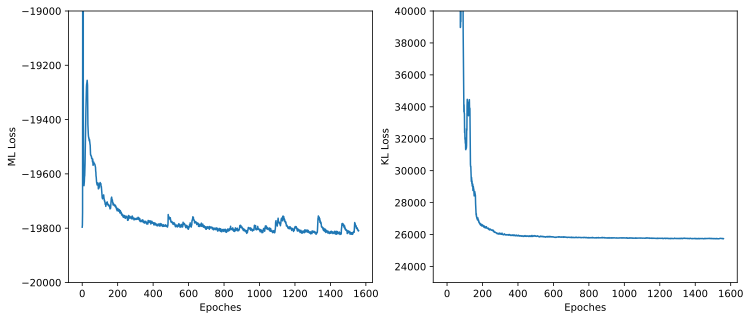

In [60]:
fig,ax = plt.subplots(1,2, figsize=[12,5])

ax[0].plot(loss_track_array[:,1])
ax[0].set_ylim(-20000,-19000)
ax[0].set_xlabel("Epoches")
ax[0].set_ylabel("ML Loss")

ax[1].plot(loss_track_array[:,2])
ax[1].set_ylim(23000,40000)
ax[1].set_xlabel("Epoches")
ax[1].set_ylabel("KL Loss")

#ax[2].plot(loss_track_array[:,3])
#ax[2].set_ylim(-10,1000)
plt.show()

### Visualization

In [12]:
bg = EnergyInvNet.load("./BG_intermediate_model_saved_TF2_longML2.pkl", mm_pdz)

Before connect
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Done xz
Done zx


In [13]:
%%time
zsamples, xsamples, zenergys, xenergys, logw = bg.sample(nsample=10000)

CPU times: user 1min 28s, sys: 47.5 s, total: 2min 16s
Wall time: 39.9 s


(0.0, 5000.0)

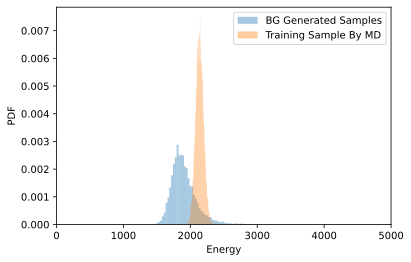

In [14]:
plt.hist(xenergys[xenergys<5000],bins=128,density=True,alpha=0.4, label="BG Generated Samples");
plt.hist(mm_pdz.energy(sim_x[::10,:]), bins=128,density=True,alpha=0.4, label='Training Sample By MD');
plt.xlabel("Energy")
plt.ylabel("PDF")
plt.legend()
plt.xlim(0,5000)

#### LEU44 and SER45 CA

In [15]:
atoms_list = list(traj.top.atoms)
atoms_list = [str(i) for i in atoms_list]
w_ILE44CA = atoms_list.index("LEU44-CA")
w_SER45CA = atoms_list.index("SER45-CA")

In [16]:
MDcoords_ILE44CA = sim_x.reshape((100000, 1655, 3))[:,w_ILE44CA,:]
BGcoords_ILE44CA = xsamples.reshape((10000,1655,3))[:,w_ILE44CA,:]

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(MDcoords_ILE44CA)

PCA(n_components=2)

In [18]:
rd_index = np.random.choice(100000, 10000, replace=False)
rd_index2 = np.random.choice(10000, 1000, replace=False)

In [19]:
MD44_PC = pca.fit_transform(MDcoords_ILE44CA)
BG44_PC = pca.fit_transform(BGcoords_ILE44CA)

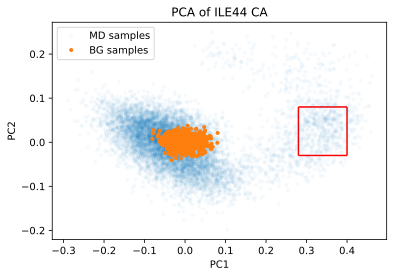

In [20]:
plt.plot(MD44_PC[rd_index,0],MD44_PC[rd_index,1], '.', alpha=0.03, label="MD samples")
plt.plot(BG44_PC[rd_index2,0],BG44_PC[rd_index2,1], '.', alpha=1, label="BG samples")
#plt.plot(BG1p544_PC[rd_index2,0],BG1p544_PC[rd_index2,1], '.', alpha=0.02, label="BG samples, higher temperature")
#plt.plot(BG2044_PC[rd_index2,0],BG2044_PC[rd_index2,1], '.', alpha=0.1, label="BG samples, Even higher")
plt.vlines(0.28, -0.03, 0.08, colors='red')
plt.vlines(0.40, -0.03, 0.08, colors='red')
plt.hlines(-0.03, 0.28, 0.40, colors='red')
plt.hlines(0.08, 0.28, 0.40, colors='red')
plt.title("PCA of ILE44 CA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [36]:
print(MD44_PC.shape)
w_ex = np.argwhere((MD44_PC[:,0] > 0.28) & (MD44_PC[:,0] < 0.40) & (MD44_PC[:,1] > -0.03) & (MD44_PC[:,1] < 0.08)).reshape(-1)
w_ground = np.argwhere(MD44_PC[:,0] < 0.12).reshape(-1)

(100000, 2)


In [37]:
print(w_ex.shape, w_ground.shape) # excited state index

(4462,) (87587,)


In [26]:
xsample_ex = sim_x[w_ex]
zsample_ex = bg.transform_xz(xsample_ex)

In [27]:
zsample_ex, logRxz_ex = bg.TxzJ.predict(xsample_ex)
zsample_ground, logRxz_ground = bg.TxzJ.predict(xsamples)

In [28]:
print("Enegy in z space:", np.sum(zsample_ex**2, axis=1).mean(), np.sum(zsample_ground**2, axis=1).mean())

Enegy in z space: 4912.103 4959.854


In [29]:
print("Entropy:", np.mean(logRxz_ex), np.mean(logRxz_ground))

Entropy: 21986.656 23705.041


In [30]:
save_latent_samples_as_trajectory(xsamples[1000:1500], top, filename="BGTF2_pdz3_batchsample_longML.pdb")

<mdtraj.Trajectory with 500 frames, 1655 atoms, 110 residues, without unitcells at 0x7fc6f1866690>

#### More samples

In [31]:
%%time
zsamples2, xsamples2, zenergys2, xenergys2, logw2 = bg.sample(nsample=100000)

CPU times: user 12min 17s, sys: 6min 43s, total: 19min 1s
Wall time: 4min 47s


In [33]:
BG2coords_ILE44CA = xsamples2.reshape((100000,1655,3))[:,w_ILE44CA,:]

In [34]:
BG244_PC = pca.fit_transform(BG2coords_ILE44CA)

In [39]:
plt.plot(MD44_PC[rd_index,0],MD44_PC[rd_index,1], '.', alpha=0.03, label="MD samples")
plt.plot(BG244_PC[rd_index,0],BG244_PC[rd_index,1], '.', alpha=1, label="BG samples")
#plt.plot(BG1p544_PC[rd_index2,0],BG1p544_PC[rd_index2,1], '.', alpha=0.02, label="BG samples, higher temperature")
#plt.plot(BG2044_PC[rd_index2,0],BG2044_PC[rd_index2,1], '.', alpha=0.1, label="BG samples, Even higher")
plt.vlines(0.28, -0.03, 0.08, colors='red')
plt.vlines(0.40, -0.03, 0.08, colors='red')
plt.hlines(-0.03, 0.28, 0.40, colors='red')
plt.hlines(0.08, 0.28, 0.40, colors='red')
plt.title("PCA of ILE44 CA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()